In [ ]:
!unzip "/content/f2b148f0502a11f0.zip" -d "/content/data"

(50771, 20)
(16924, 19)
      ID  Average_Temperature Organic_Manure Soil_Type Field_size Crop_Type  \
0  19930                 29.0            Yes         3        NaN         5   
1  23524                 22.0            Yes         5        100         5   
2  58466                 21.0             No         2       26.0         6   
3  42510                 35.0            Yes         4        100         6   
4  49842                  NaN            Yes         4        100         6   

  Climatic_Conditions Pesticide_Used Plant_Disease Irrigation_availability  \
0                   4            Yes           Yes                    high   
1                   4            Yes            No                    high   
2                   4            Yes           Yes                     low   
3                   5            Yes           Yes                    high   
4                   4            Yes           Yes                    high   

  Natural_calamity Fertilizers_u

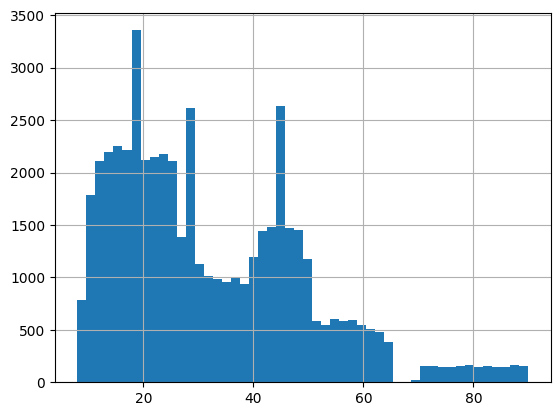

In [ ]:
import pandas as pd
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print(train.shape)  # (50771, 20)
print(test.shape)   # (16924, 19)
print(train.head())


train['Crop_Damage'].hist(bins=50)


print(train.isna().mean().sort_values(ascending=False).head())


In [ ]:
print(train.head())
print(train.info())
print(train.describe(include='all'))

      ID  Average_Temperature Organic_Manure Soil_Type Field_size Crop_Type  \
0  19930                 29.0            Yes         3        NaN         5   
1  23524                 22.0            Yes         5        100         5   
2  58466                 21.0             No         2       26.0         6   
3  42510                 35.0            Yes         4        100         6   
4  49842                  NaN            Yes         4        100         6   

  Climatic_Conditions Pesticide_Used Plant_Disease Irrigation_availability  \
0                   4            Yes           Yes                    high   
1                   4            Yes            No                    high   
2                   4            Yes           Yes                     low   
3                   5            Yes           Yes                    high   
4                   4            Yes           Yes                    high   

  Natural_calamity Fertilizers_used  Fertilizers_cost Wa

In [4]:

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

X       = train.drop(columns=["ID","Crop_Damage"])
y       = train["Crop_Damage"].astype(float)
X_test  = test.drop(columns=["ID"])
test_ids = test["ID"]

cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
preprocessor = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
], remainder="passthrough")

model = Pipeline([
    ("preproc", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
])

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = []
for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X_tr), total=kf.n_splits, desc="CV folds")):
    model.fit(X_tr.iloc[train_idx], y_tr.iloc[train_idx])
    preds = model.predict(X_tr.iloc[val_idx])
    #rmse  = mean_squared_error(y_tr.iloc[val_idx], preds, squared=False)
    mse   = mean_squared_error(y_tr.iloc[val_idx], preds)
    rmse  = np.sqrt(mse)
    cv_scores.append(rmse)

print(f"\nCV RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


model.fit(X_tr, y_tr)
val_pred = model.predict(X_val)

test_preds = []
for i in tqdm(range(len(X_test)), desc="Test predictions"):

    test_preds.append(model.predict(X_test.iloc[[i]])[0])
test_preds = np.array(test_preds)

submission = pd.DataFrame({"ID": test_ids, "Crop_Damage": test_preds})
submission.to_csv("my_submission.csv", index=False)
print("Saved my_submission.csv:", submission.shape)


CV folds:   0%|          | 0/3 [00:00<?, ?it/s]


CV RMSE: 8.2160 ± 0.0565


Test predictions:   0%|          | 0/16924 [00:00<?, ?it/s]

Saved my_submission.csv: (16924, 2)


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score


train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
X, y = train.drop(["ID","Crop_Damage"], axis=1), train["Crop_Damage"].astype(float)
X_test, test_ids = test.drop("ID", axis=1), test["ID"]

cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num_imp", SimpleImputer(strategy="median"), num_cols),
    ("cat_imp", Pipeline([
        ("impute", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
        ("ohe",    OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols),
], remainder="drop")

base_models = [
    ("rf", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
    ("gb", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
]
stack = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV(alphas=[0.1,1.0,10.0]),
    n_jobs=-1, passthrough=False
)

model = Pipeline([
    ("prep", preprocessor),
    ("stack", stack),
])


X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, val_idx in tqdm(kf.split(X_tr), total=kf.get_n_splits(), desc="CV folds"):
    model.fit(X_tr.iloc[train_idx], y_tr.iloc[train_idx])
    preds = model.predict(X_tr.iloc[val_idx])
    mse   = mean_squared_error(y_tr.iloc[val_idx], preds)
    rmse  = np.sqrt(mse)
    rmse_scores.append(rmse)

rmse_scores = np.array(rmse_scores)
print(f"Manual CV RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")


from tqdm_joblib import tqdm_joblib

with tqdm_joblib(tqdm(desc="cross_val_score", total=kf.get_n_splits())):
    scores = -cross_val_score(
        model, X_tr, y_tr,
        cv=kf,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
print(f"cross_val_score RMSE: {scores.mean():.4f} ± {scores.std():.4f}")

model.fit(X_tr, y_tr)

test_preds = model.predict(X_test)
submission = pd.DataFrame({
    "ID": test_ids,
    "Crop_Damage": test_preds
})
submission.to_csv("my_submission.csv", index=False)
print("Saved my_submission.csv:", submission.shape)



CV folds:   0%|          | 0/3 [00:00<?, ?it/s]

Manual CV RMSE: 8.2159 ± 0.0537


cross_val_score:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]